# Reducing Monetary Loss w/ Prediction Algorithms
Megan Riley, Jaclyn Coate, and Reagan Meagher

## 1 Objective
Our client has provided data to build a prediction algorithm to mimize monetary loss. The data has been given to us with no background or metadata. The following report details those efforts in order to minimize monetary loss by maximizing precision on the prediction algorithm built for the client. The below details were outlined in order to provide direction of our modeling efforts:


### List 1.1: Monetary Loss by Measurement
* False Positive: for every false positive there is a 225 dollar loss
* False Negative: for every false negative there is a 35 dollar loss


When leveraging machine learning algorithms there are many models to choose from. However, all models perform differently when applied to the same datasets. In order to solve our problem we chose 3 main different models as candidates to help us with our business needs. Allowing us to have a broader understanding of the data and enable us to find the best solution. Our models of choice were Random Forest, Stochastic Gradient Descent with Logistic Regularization, and XGBoost. In execution of all models the monetary loss above is taken into account.

## 2 Data & Package Load

[Data](https://smu.app.box.com/s/k9x192jxm39enjw2wx8ouw2kopx33l32)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import metrics

In [ ]:
# To correctly load data from googledrive. 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
data_location = "https://drive.google.com/file/d/1FcHhkyZIOqc7CDsYsCwp4MHOz6ixZCaF/view?usp=sharing"
file_id = "1FcHhkyZIOqc7CDsYsCwp4MHOz6ixZCaF"

In [ ]:
downloaded = drive.CreateFile({'id':file_id})
downloaded.GetContentFile('final_project.csv') 

rawData = pd.read_csv('final_project.csv')
rawData.shape

(160000, 51)

## 3 Exploratory Data Analysis

The data used to train these models included no metadata or further information describing the problem of classification at hand. It included 160,000 observations of fifty features. Without the additional information, we could not explore detailed feature creation. After some exploration we found minimal issues with multicollinearity. Most features were uncorrelated or had minimal correlation. This exploration gave us minimal additional information to inform our models or concerns with multicollinearity going forward. 


### 3.1 Raw Data Table Review of Top 4 Observations

In [ ]:
rawData.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
0,-0.166563,-3.961588,4.621113,2.481908,-1.800135,0.804684,6.718751,-14.789997,-1.040673,-4.204950,6.187465,13.251523,25.665413,-5.017267,10.503714,-2.517678,2.117910,5.865923,-6.666158,1.791497,-1.909114,-1.737940,-2.516715,3.553013,euorpe,-0.801340,1.142950,1.005131,-18.473784,July,tuesday,-3.851669,0.0%,-1.940031,-5.492063,0.627121,-0.873824,$1313.96,-1.353729,-5.186148,-10.612200,-1.497117,5.414063,-2.325655,1.674827,-0.264332,60.781427,-7.689696,0.151589,-8.040166,0
1,-0.149894,-0.585676,27.839856,4.152333,6.426802,-2.426943,40.477058,-6.725709,0.896421,0.330165,-11.708859,-2.352809,-25.014934,9.799608,-10.960705,1.504000,-2.397836,-9.301839,-1.999413,5.045258,-5.809984,10.814319,-0.478112,10.590601,asia,0.818792,-0.642987,0.751086,3.749377,Aug,wednesday,1.391594,-0.02%,2.211462,-4.460591,1.035461,0.228270,$1962.78,32.816804,-5.150012,2.147427,36.292790,4.490915,0.762561,6.526662,1.007927,15.805696,-4.896678,-0.320283,16.719974,0
2,-0.321707,-1.429819,12.251561,6.586874,-5.304647,-11.311090,17.812850,11.060572,5.325880,-2.632984,1.572647,-4.170771,12.078602,-5.158498,7.302780,-2.192431,-4.065428,-7.675055,4.041629,-6.633628,1.700321,-2.419221,2.467521,-5.270615,asia,-0.718315,-0.566757,4.171088,11.522448,July,wednesday,-3.262082,-0.01%,0.419607,-3.804056,-0.763357,-1.612561,$430.47,-0.333199,8.728585,-0.863137,-0.368491,9.088864,-0.689886,-2.731118,0.754200,30.856417,-7.428573,-2.090804,-7.869421,0
3,-0.245594,5.076677,-24.149632,3.637307,6.505811,2.290224,-35.111751,-18.913592,-0.337041,-5.568076,-2.000255,-19.286668,10.995330,-5.914378,2.511400,1.292362,-2.496882,-15.722954,-2.735382,1.117536,1.923670,-14.179167,1.470625,-11.484431,asia,-0.052430,-0.558582,9.215569,30.595226,July,wednesday,-2.285241,0.01%,-3.442715,4.420160,1.164532,3.033455,$-2366.29,14.188669,-6.385060,12.084421,15.691546,-7.467775,2.940789,-6.424112,0.419776,-72.424569,5.361375,1.806070,-7.670847,0
4,-0.273366,0.306326,-11.352593,1.676758,2.928441,-0.616824,-16.505817,27.532281,1.199715,-4.309105,6.667530,1.965913,-28.106348,-1.258950,5.759941,0.472584,-1.150097,-14.118709,4.527964,-1.284372,-9.026317,-7.039818,-1.978748,-15.998166,asia,-0.223449,0.350781,1.811182,-4.094084,July,tuesday,0.921047,0.01%,-0.431640,12.165494,-0.167726,-0.341604,$-620.66,-12.578926,1.133798,30.004727,-13.911297,-5.229937,1.783928,3.957801,-0.096988,-14.085435,-0.208351,-0.894942,15.724742,1


### 3.2 Raw Data Table Description Statistics of Variables

In [ ]:
rawData.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x25,x26,x27,x28,x31,x33,x34,x35,x36,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
count,159974.000000,159975.000000,159962.000000,159963.000000,159974.000000,159963.000000,159974.000000,159973.000000,159979.000000,159970.000000,159957.000000,159970.000000,159964.000000,159969.000000,159966.000000,159965.000000,159974.000000,159973.000000,159960.000000,159965.000000,159962.000000,159971.000000,159973.000000,159953.000000,159978.000000,159964.000000,159970.000000,159965.000000,159961.000000,159959.000000,159959.000000,159970.000000,159973.000000,159969.000000,159977.000000,159964.000000,159960.000000,159974.000000,159963.000000,159960.000000,159971.000000,159969.000000,159963.000000,159968.000000,159968.000000,160000.000000
mean,-0.001028,0.001358,-1.150145,-0.024637,-0.000549,0.013582,-1.670670,-7.692795,-0.030540,0.005462,0.002253,0.030232,-1.334402,0.007669,0.008104,0.001215,0.006223,0.012040,0.012694,0.024555,0.299074,-0.029137,0.008400,0.722028,-0.000806,-0.001066,-0.004159,0.031543,-0.005945,-0.006567,-0.000426,0.000936,0.006453,6.059130,0.004253,-2.316526,6.701076,-1.833820,-0.002091,-0.006250,0.000885,-12.755395,0.028622,-0.000224,-0.674224,0.401231
std,0.371137,6.340632,13.273480,8.065032,6.382293,7.670076,19.298665,30.542264,8.901185,6.355040,7.871429,8.769633,14.750990,8.953837,6.964097,3.271779,4.984065,7.569351,4.540714,7.595316,5.806203,9.409635,5.412010,14.909127,1.263656,0.843258,6.774047,14.439534,2.767508,1.747762,8.014180,2.379558,1.593183,16.891603,5.134322,17.043549,18.680196,5.110705,1.534952,4.164595,0.396621,36.608641,4.788157,1.935501,15.036738,0.490149
min,-1.592635,-26.278302,-59.394048,-35.476594,-28.467536,-33.822988,-86.354483,-181.506976,-37.691045,-27.980659,-36.306571,-38.092869,-64.197967,-38.723514,-30.905214,-17.002359,-26.042983,-34.395898,-20.198686,-35.633396,-26.677396,-43.501854,-23.644193,-66.640341,-6.364653,-3.857484,-32.003555,-72.896705,-12.289364,-7.451454,-36.116606,-10.008149,-6.866024,-74.297559,-22.101647,-74.059196,-82.167224,-27.933750,-6.876234,-17.983487,-1.753221,-201.826828,-21.086333,-8.490155,-65.791191,0.000000
25%,-0.251641,-4.260973,-10.166536,-5.454438,-4.313118,-5.148130,-14.780146,-27.324771,-6.031058,-4.260619,-5.288196,-5.903274,-11.379492,-6.029945,-4.696755,-2.207774,-3.344027,-5.071470,-3.056131,-5.101553,-3.607789,-6.361115,-3.649766,-9.268532,-0.852784,-0.567293,-4.597919,-9.702464,-1.874206,-1.183681,-5.401084,-1.610337,-1.068337,-5.249882,-3.458716,-13.953629,-5.804080,-5.162869,-1.039677,-2.812055,-0.266518,-36.428329,-3.216016,-1.320800,-10.931753,0.000000
50%,-0.002047,0.004813,-1.340932,-0.031408,0.000857,0.014118,-1.948594,-6.956789,-0.016840,0.006045,-0.018176,0.010941,-1.624439,-0.003473,0.002467,0.003535,0.012754,0.024541,0.015904,0.044703,0.433055,-0.026385,0.011144,1.029609,-0.003723,-0.001501,0.037138,0.244210,0.002013,-0.006079,-0.013089,-0.002399,0.003645,6.184410,0.019068,-2.701867,6.840110,-1.923754,-0.004385,-0.010484,0.001645,-12.982497,0.035865,-0.011993,-0.574410,0.000000
75%,0.248532,4.284220,7.871676,5.445179,4.306660,5.190749,11.446931,12.217071,5.972349,4.305734,5.331573,5.935032,8.374524,6.041959,4.701299,2.211660,3.366853,5.101962,3.073002,5.164732,4.306566,6.316457,3.672678,11.028035,0.851765,0.567406,4.649773,9.936995,1.856369,1.179460,5.411667,1.603089,1.079895,17.420148,3.463308,8.981616,19.266367,1.453507,1.033275,2.783274,0.269049,11.445443,3.268028,1.317703,9.651072,1.000000
max,1.600849,27.988178,63.545653,38.906025,26.247812,35.550110,92.390605,149.150634,39.049831,27.377842,37.945583,36.360443,73.279354,42.392177,32.546340,13.782559,21.961123,37.057048,19.652986,33.515550,27.814560,46.237503,24.863012,58.490500,5.314169,3.951652,28.645074,67.753845,12.279356,7.787120,34.841428,9.892426,6.999544,90.467981,21.545591,88.824477,100.050432,22.668041,6.680922,19.069759,1.669205,150.859415,20.836854,8.226552,66.877604,1.000000


### 3.3 Data Variable Type Discovery

In [ ]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 51 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x0      159974 non-null  float64
 1   x1      159975 non-null  float64
 2   x2      159962 non-null  float64
 3   x3      159963 non-null  float64
 4   x4      159974 non-null  float64
 5   x5      159963 non-null  float64
 6   x6      159974 non-null  float64
 7   x7      159973 non-null  float64
 8   x8      159979 non-null  float64
 9   x9      159970 non-null  float64
 10  x10     159957 non-null  float64
 11  x11     159970 non-null  float64
 12  x12     159964 non-null  float64
 13  x13     159969 non-null  float64
 14  x14     159966 non-null  float64
 15  x15     159965 non-null  float64
 16  x16     159974 non-null  float64
 17  x17     159973 non-null  float64
 18  x18     159960 non-null  float64
 19  x19     159965 non-null  float64
 20  x20     159962 non-null  float64
 21  x21     15

### 3.4 Correlation Heat Map for Multicolinearity Check

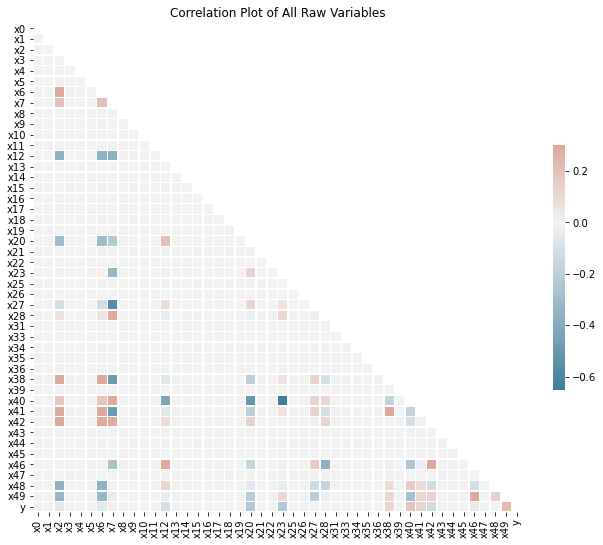

In [ ]:


##Overall build a corr grid graphic
#Build Correlation grid
corr_chart = rawData.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_chart, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax.set_title("Correlation Plot of All Raw Variables")
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_chart, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 3.5 Data Cleaning

This data is overall quite clean with a few issues that require addressing. First we found a certain number of NA values appeared in the dataset. We found that those NA values could be eliminated with listwise deletion and only remove 1% of the dataset overall. With this minimal removal we chose to move forward with listwise deletion of NA values. 

We also found five features in our dataset that were not some float or integer data type for modeling. Two of those features had extraneous characters, the *%* and the *$* characters which required light cleaning to convert the features to numeric. The final three features were categorical describing the month, day of week and general geographic location. We one-hot encoded those categorical features to the inclusion of twenty additional variables. While we noted spelling errors in the categories, they were consistently misspelled and did not create issues with multiple columns reflecting the same categories. After this cleaning of features we had sixty seven features with which to build our model.


In [ ]:
#Dropping NAs only costs about 1% of the data

cleanData = rawData.dropna(axis = 0)
cleanData.shape


(158392, 51)

After exploration we found five columns that were not numerical, three were categorical and two were numerical columns with characters included. We will proceed with stripping the characters out of the last two and one-hot-encoding the first three. 

In [ ]:
#Description of Non - Numeric Values
print("X24 Levels: ",cleanData["x24"].unique())
print("X29 Levels: ",cleanData["x29"].unique())
print("X30 Levels: ",cleanData["x30"].unique())

#Exploration of Numeric values changed 
print("X32 Levels: ",cleanData["x32"].unique())
print("X37 Levels: ",cleanData["x37"].unique())


X24 Levels:  ['euorpe' 'asia' 'america']
X29 Levels:  ['July' 'Aug' 'Jun' 'May' 'sept.' 'Apr' 'Nov' 'Oct' 'Mar' 'Feb' 'Dev'
 'January']
X30 Levels:  ['tuesday' 'wednesday' 'thurday' 'monday' 'friday']
X32 Levels:  ['0.0%' '-0.02%' '-0.01%' '0.01%' '-0.03%' '0.02%' '-0.0%' '-0.04%'
 '0.03%' '0.04%' '-0.05%' '0.05%']
X37 Levels:  ['$1313.96' '$1962.78' '$430.47' ... '$1588.65' '$439.21' '$-1229.34']


In [ ]:
#Stripping Extra Characters
#Ignore or clear warnings
cleanData['x32'] = cleanData['x32'].astype(str).str.replace('%','').astype('float64')
cleanData['x37'] = cleanData['x37'].astype(str).str.replace('$','').astype('float64')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
#Variables no longer show $ or % characters and are floats.
print("X32 Levels: ",cleanData["x32"].unique())
print("X37 Levels: ",cleanData["x37"].unique())


X32 Levels:  [ 0.   -0.02 -0.01  0.01 -0.03  0.02 -0.04  0.03  0.04 -0.05  0.05]
X37 Levels:  [ 1313.96  1962.78   430.47 ...  1588.65   439.21 -1229.34]


In [ ]:
one_hot_encoded_cols = ['x24','x29','x30']

for col in one_hot_encoded_cols:
  cleanData = pd.concat([cleanData,pd.get_dummies(cleanData[col], prefix = str(col))],axis=1)

cleanData = cleanData.drop(one_hot_encoded_cols, axis = 1)

### 3.6 Correlation Heat Map to Display One Hot Encodings

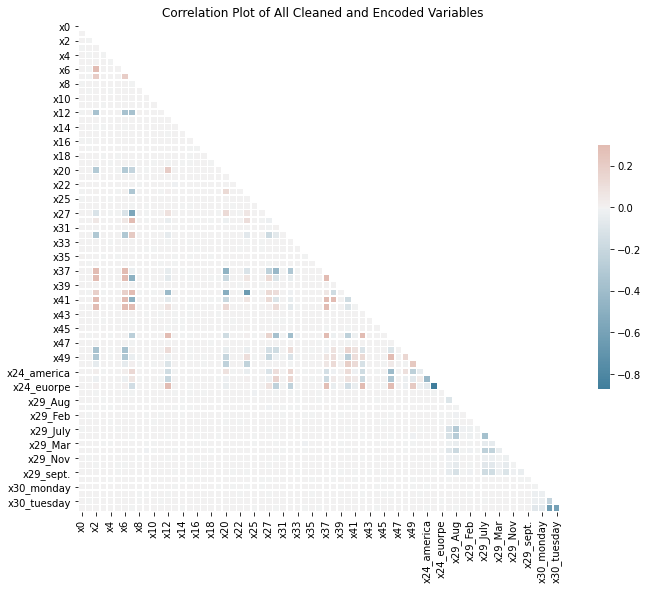

In [ ]:

##Overall build a corr grid graphic w/ one hot encodings
#NOTE : Chart is too small to have all labeled variables. 
#Build Correlation grid
corr_chart_clean = cleanData.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_chart_clean, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax.set_title("Correlation Plot of All Cleaned and Encoded Variables")


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_chart_clean, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 4 Model Building

In order to begin training of all of our models we built a train and test split that gave us access to a validation set to test and predict tuned models on. This validation set is in addition to a five fold cross validation being performed for each model hyperparameter tuning grid search. 

For use in each model we also created and tuned to a scorer using precision as our model metric of choice. We chose to use precision over recall or accuracy because it includes a measure of false positives, which is the more heavily penalized misclassification category in terms of monetary losses. With models tuned towards precision, we expect our dollar loss through incorrect classifications to be minimized. 


In [ ]:
from sklearn.model_selection import train_test_split

target = cleanData['y']
cleanData = cleanData.drop('y', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(cleanData,
                                                    target,
                                                    test_size=0.1,
                                                    random_state=72)

In [ ]:
X_train.shape

(142552, 67)

In [ ]:
#make scorer and bring in metrics to use later
from sklearn.metrics import precision_score, make_scorer, recall_score, confusion_matrix, accuracy_score

fp_scorer = make_scorer(precision_score)

accuracy_scorer = make_scorer(accuracy_score)

### 4.1 Random Forest

A Random Forest model is the initial model we used to predict the unknown values for our target variable. The Random Forest model is considered a bootstrap tree-based model and uses an ensembling technique with simplistic learning decisions. These models are often described as easy to overfit but are also highly reliable. This means it is a good starting point for us to get an idea of what the classification prediction will look like for our models. Additionally, giving us our first look into what the monetary loss level will be for the models. Tunnig for precision below are our hyperparameter settings for our final Random Forest model fit.
#### Table 4.1.1: Random Forest Hyperparameter Definitions
 
|Hyperparameter|Controls|
|--|:--|
|n_estimators|Specifies the number of trees in the forest of the model.|
|min_samples_leaf|Specifies the minimum number of samples required to be at a leaf node.|
|min_samples_split|Specifies the minimum number of samples required to split an internal leaf node.|
|Max_Depth|Specifies the maximum depth of each tree.|

#### Table 4.1.2: Random Forest Hyperparameter Settings
 
|Hyperparameter|Range|Final Value|
|--|:--|:--|
|n_estimators|50,100,150|100|
|min_samples_leaf|5,10|2|
|min_samples_split|2, 5, 10|5|
|Max_Depth|1, 2, 5|10|

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


n_estimators = [50,100,150]
max_depth = [5,10]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5] 


hyperparams = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)
rf = RandomForestClassifier()
gridF = GridSearchCV(rf, hyperparams, scoring = fp_scorer,
                     cv = 5, verbose = 10,  n_jobs = -1)
bestrf = gridF.fit(X_train, y_train)
#2.3 min one iteration w/ 5 cv

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 39.7min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 46.8min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 54.7min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 62.9min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 73

CPU times: user 2min 34s, sys: 6.8 s, total: 2min 41s
Wall time: 3h 11min 29s


In [ ]:
bestrf

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
bestrf.best_params_

best_rf_parameters = ['max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100]

 full_rf_estimator = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

In [ ]:
bestrf.best_score_

0.9044173870199999

#### Final Random Forest Fit and Prediction

In [ ]:
from sklearn.ensemble import RandomForestClassifier


'''best_rf_parameters = ['max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100]'''

rfbest = RandomForestClassifier(max_depth = 10, min_samples_leaf = 2,
                                min_samples_split = 5, n_estimators = 100)
rfbest.fit(X_train, y_train)
rf_preds = rfbest.predict(X_test)

##### Random Forest Precision & Confusion Matrix

In [ ]:

print("Accuracy: ", accuracy_score(y_test,rf_preds))
print("Precision: ", precision_score(y_test,rf_preds))
print("Recall: ", recall_score(y_test,rf_preds))
print("Confusion Matrix: ", confusion_matrix(y_test, rf_preds))

Accuracy:  0.8734217171717171
Precision:  0.9201513718070009
Recall:  0.7544213465715173
Confusion Matrix:  [[8972  422]
 [1583 4863]]


##### Random Forest Monetary Loss

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, rf_preds).ravel()
print("False Positives: ", fp)
print("False Negatives: ", fn)
dollars = (225 * fp) + (35 * fn)
print("Dollars Lost: $", dollars , " for ", len(y_test), " predictions.")

False Positives:  422
False Negatives:  1583
Dollars Lost: $ 150355  for  15840  predictions.




### 4.2 Regularized Logistic Regression

In this model we used a Logistic Regression model with Elastic Net tuning to prevent overfitting. This was built with the SGDClassifier tool in sklearn and used logistic regression as an objective function to optimize. Like other models we tuned with a scorer of precision. In order to prevent overfitting we used an option of L1 to L2 ratios with several levels of alpha for the ratio itself. The best values found was an L1 ratio of .7, which brings the ratio closer to L2 regularization with a large alpha of .05. Despite the tuning this model performed worse than our other options we have available but is incredibly fast to build. 


#### Table 4.1.1: Logistic Regression Hyperparameter Definitions
 
|Hyperparameter|Controls|
|--|:--|
|alpha|Specifies the constant that multiplies the regularization term. Commonly also know as lambda.|
|l1_ratio|Specifies the ratio for L1 to L2 regularization.|

#### Table 4.1.2: Logistic Regression Hyperparameter Settings
 
|Hyperparameter|Range|Final Value|
|--|:--|:--|
|alpha|.1,.05,.01,.005,.0001|.05|
|l1_ratio| .1, .5, .7, .9, .95, 1|1|

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

loss = ['log']
penalty = ['elasticnet']
l1_ratio = [.1, .5, .7, .9, .95, 1]
alpha = [.1,.05,.01,.005,.0001]
warm_start = ['True']

hyperparams = dict(l1_ratio = l1_ratio, alpha = alpha)
logit = SGDClassifier()
gridlog = GridSearchCV(logit, hyperparams, cv = 5, scoring = fp_scorer,
                       verbose = 10,  n_jobs = -1)
bestlog = gridlog.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 18

In [ ]:
bestlog

GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.1, 0.05, 0.01, 0.005, 0.0001],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False

In [ ]:
final = {'alpha': 0.1, 'l1_ratio': 0.7}
bestlog.best_params_


{'alpha': 0.1, 'l1_ratio': 0.7}

In [ ]:
bestlog.best_score_

0.6795297879896744

#### Final Logistic Regression Fit and Prediction

In [ ]:
from sklearn.linear_model import SGDClassifier


logbest = SGDClassifier(alpha = .05, l1_ratio = .71)
logbest.fit(X_train, y_train)
log_preds = logbest.predict(X_test)

##### Logistic Regression Precision & Confusion Matrix

In [ ]:

print("Accuracy: ", accuracy_score(y_test,log_preds))
print("Precision: ", precision_score(y_test,log_preds))
print("Recall: ", recall_score(y_test,log_preds))
print("Confusion Matrix: ", confusion_matrix(y_test, log_preds))

Accuracy:  0.6875
Precision:  0.6657066902968543
Recall:  0.46618057710207883
Confusion Matrix:  [[7885 1509]
 [3441 3005]]


##### Logistic Regression Monetary Loss

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, log_preds).ravel()
print("False Positives: ", fp)
print("False Negatives: ", fn)
dollars = (225 * fp) + (35 * fn)
print("Dollars Lost: $", dollars , " for ", len(y_test), " predictions.")

False Positives:  1509
False Negatives:  3441
Dollars Lost: $ 459960  for  15840  predictions.


### 4.3 XGBoost



The XGBoost, or eXtreme Gradient Boosting model, is a sophisticated algorithm that works well with unknown data. It is important for these more advanced machine learning tools to be tuned properly in order to allow for the algorithm to work correctly. _Table 4.3.1_ contains those hyperparameters and what they help control in this model. _Table 4.3.2_ contains those hyperparameters setting that were identified to use through a grid search process. There is standard regularization in XGBoost that allows us to prevent overfitting. With the powerful parallel processing we found this model to be the most economical in computing power as well as return the top performance and therefore lowest monetary loss thus far.
#### Table 4.3.1: XGBoost Hyperparameter Definitions
 
|Hyperparameter|Controls|
|--|:--|
|Booster|Specifies which booster to use|
|Lambda|L2 regularization to prevent overfitting.|
|Learning Rate|Controls the shrinkage of the weights associated to features after each round. Makes model more robust to overfitting, lower the rate, the better.
|Max_Depth|Maximum number of nodes allowed from root to farthest leaf of tree. Deeper trees are more complex but then splits can become less relevant and can cause the model to overfit.|
|Min_Child_Weight|Minimum weight required in order to create a new node in the tree. A smaller number allows the algorithm to create children that correspond to fewer samples. Enables more complex trees, but likely to overfit.|
|Objective|Measure of performance of the model given these set of parameters.|
|Subsample|Ratio of the training instance.| 


#### Table 4.3.2: XGBoost Hyperparameter Settings
 
|Hyperparameter|Range|Final Value|
|--|:--|:--|
|Booster|n/a|gbtree|
|Lambda|.9,1,1.1|0.9|
|Learning Rate|0.1,.3|0.3|
|Max_Depth| 4,6,7|7|
|Min_Child_Weight|1,2|1|
|Objective|n/a|binary:logistic|

In [ ]:

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier()

xgboost_params = {"booster": ["gbtree"],'objective':['binary:logistic'],
              'learning_rate': [0.1,.3], 
              'max_depth': [4,6,7],
              'min_child_weight': [1,2],
              'subsample': [0.8],
              'lambda': [.9,1,1.1]
              }

xgb_clf = GridSearchCV(xgb_model, xgboost_params, n_jobs=-1, cv=5, 
                   scoring=fp_scorer,verbose=10)


best_xgb = xgb_clf.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 36.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 58.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 66.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 81.2min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 94.5min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 109.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 125.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 

In [ ]:
best_xgb

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_po...e, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'booster': ['gbtree'], 'lambda': [0.9, 1, 1.1],
                         'learning_rate': [0.1, 0.3], 'max_depth': [4, 6, 7],
                         'min_child_weight': 

In [ ]:
best_xgb_params = {'booster': 'gbtree',
 'lambda': 0.9,
 'learning_rate': 0.3,
 'max_depth': 7,
 'min_child_weight': 1,
 'objective': 'binary:logistic',
 'subsample': 0.8}

best_xgb.best_params_

{'booster': 'gbtree',
 'lambda': 0.9,
 'learning_rate': 0.3,
 'max_depth': 7,
 'min_child_weight': 1,
 'objective': 'binary:logistic',
 'subsample': 0.8}

In [ ]:
best_xgb.best_score_

0.9204078970874658

#### Final XGBoost Fit and Prediction

In [ ]:
import xgboost as xgb
#fitting differently to include early stopping
xgboost_params = {'booster': 'gbtree',
 'lambda': 0.9,
 'learning_rate': 0.3,
 'max_depth': 7,
 'min_child_weight': 1,
 'objective': 'binary:logistic',
 'subsample': 0.8}

xgb_data = xgb.DMatrix(X_train, y_train)
xgb_test = xgb.DMatrix(X_test, y_test)
clf = xgb.train(xgboost_params,xgb_data,num_boost_round=50,verbose_eval=True,maximize=False)

xgb_preds = clf.predict(xgb_test)


In [ ]:
xgb_class_preds = np.rint(xgb_preds)

##### XGBoost Precision & Confusion Matrix

In [ ]:

print("Accuracy: ", accuracy_score(y_test,xgb_class_preds))
print("Precision: ", precision_score(y_test,xgb_class_preds))
print("Recall: ", recall_score(y_test,xgb_class_preds))
print("Confusion Matrix: ", confusion_matrix(y_test, xgb_class_preds))

Accuracy:  0.9287878787878788
Precision:  0.925712455971822
Recall:  0.8969903816320198
Confusion Matrix:  [[8930  464]
 [ 664 5782]]


##### XGBoost Monetary Loss

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, xgb_class_preds).ravel()
print("False Positives: ", fp)
print("False Negatives: ", fn)
dollars = (225 * fp) + (35 * fn)
print("Dollars Lost: $", dollars , " for ", len(y_test), " predictions.")

False Positives:  464
False Negatives:  664
Dollars Lost: $ 127640  for  15840  predictions.


## 5 Results

#### Table 5.1: Random Forest Results
 
|Success Measure|Result|
|--|:--|
|Accuracy|.878|
|Precision|.923|
|Recall|.763|
|False Positives|411|
|False Negatives|1524|
|Classifications|15,840|
|Dollars Lost|`$145,815`|


#### Table 5.2: Logistic Regression Results
 
|Success Measure|Result|
|--|:--|
|Accuracy|.680|
|Precision|.646|
|Recall|.472|
|False Positives|1671|
|False Negatives|3401|
|Classifications|15,840|
|Dollars Lost|`$495,010`|

#### Table 5.3: XGBoost Results
 
|Success Measure|Result|
|--|:--|
|Accuracy|.929|
|Precision|.926|
|Recall|.870|
|False Positives|464|
|False Negatives|664|
|Classifications|15,840|
|Dollars Lost|`$127,640`|

#### Table 5.4: Dollars Loss by Model per 1000 Classification

|Model|Monetary Loss per 1000 Classifications|
|:---|:---|
|Random Forest| `$9,205`|
|Logistic Regression| `$31,250`|
|XGBoost|`$8,058`|





## Conclusion

Upon build, execution, and review of results the XGBoost model outperformed all other classification models. When tuning to precision to take into account the measure of false positives, we were able to refine the XGBoost model to have no more than `$127,640` monetary loss when used to classify the 15,840 test dataset. This translates to a ~`$8,058` loss per 1000 classified observations. 

Should the client need any predictions moving forward, with the same data source, we recommend our client use this model to continue to benefit from a model that has been specifically tuned for these data and variables. If the client has any changes to their data, we advise a new data evaluation and model build. This model has been specifically trained and would not be applicable to the data should it change or evolve in any way. 
